In [1]:
# Import system modules
from os.path import getsize, join
from shutil import copyfile
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
# Import numpy
import warnings
import numpy as np
import obspy
from seisflows.tools.tools import iterable
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

In [2]:
def read_slice(path, parameters, iproc):
    """ Reads SPECFEM model slice(s)
        Such as, for example : proc000005_vp.bin
        In that specific case it would be : read_slice(path, 'vp', 5)
    """
    vals = []
    for key in parameters:
        filename = '%s/proc%06d_%s.bin' % (path, iproc, key)
        vals += [_read(filename)]
    return vals

def _read(filename):
    """ Reads Fortran style binary data into numpy array
    """
    nbytes = getsize(filename)
    with open(filename, 'rb') as file:
        # read size of record
        file.seek(0)
        n = np.fromfile(file, dtype='int32', count=1)[0]
        if n == nbytes-8:
            file.seek(4)
            data = np.fromfile(file, dtype='float32')
            return data[:-1]
        else:
            file.seek(0)
            data = np.fromfile(file, dtype='float32')
            return data

In [3]:
def readStations(path):
    """ Read specfem2d STATIONS file
    """
    with warnings.catch_warnings():  # Suppress warning about single precision
        warnings.simplefilter("ignore")
        stats = np.genfromtxt(path, usecols=(0, 2, 3), dtype=None)
    temp = [list(u) for u in stats]
    temp = map(list, zip(*temp))
    return temp[:][0], np.array(temp[:][1]), np.array(temp[:][2])

In [4]:
def readSources(path, NSRC):
    """Read specfem2d SOURCE file with standard 14 parameter
    """
    xs = []
    zs = []
    for i in range(NSRC):
        data = np.genfromtxt(path + "/SOURCE_" + str(i).zfill(6))
        temp = [list(u) for u in [data[:,2]]]
        temp = map(list, zip(*temp))
        xs += temp[1]
        zs += temp[2]
    return xs, zs

In [5]:
namesStats, xStats, zStats = readStations('./specfem2d/DATA/STATIONS')
xSources, zSources = readSources('./specfem2d/DATA/', NSRC = 15)

In [16]:
ITER = 10
#pars = ["vp_kernel"]
pars = ["vp_kernel"]
NPROC = 3
if ITER is 0:
    PATH = './output/model_init/'
elif ITER is -1:
    PATH = './output/model_true/'
#     PATH = './model_temp'
else:
#     PATH = './output/model_' + str(ITER).zfill(4) + '/'
    PATH = './output/gradient_' + str(ITER).zfill(4) + '/'
#PATH = './scratch/solver/000000/DATA/'

DATA = {}
for PROC in range(NPROC):
    for COORD in ['x', 'z']:
        if PROC ==0:
            DATA[COORD] = read_slice(path = './output/model_init', parameters = [COORD], iproc = PROC)
        else:
            DATA[COORD][0] = np.append(DATA[COORD][0], read_slice(path = './output/model_init', parameters = [COORD], iproc = PROC))
    for PAR in pars:
        if PROC == 0:
            DATA[PAR] = read_slice(path = PATH, parameters = [PAR], iproc = PROC)
        else:
            DATA[PAR][0] = np.append(DATA[PAR][0], read_slice(path = PATH, parameters = [PAR], iproc = PROC))
        

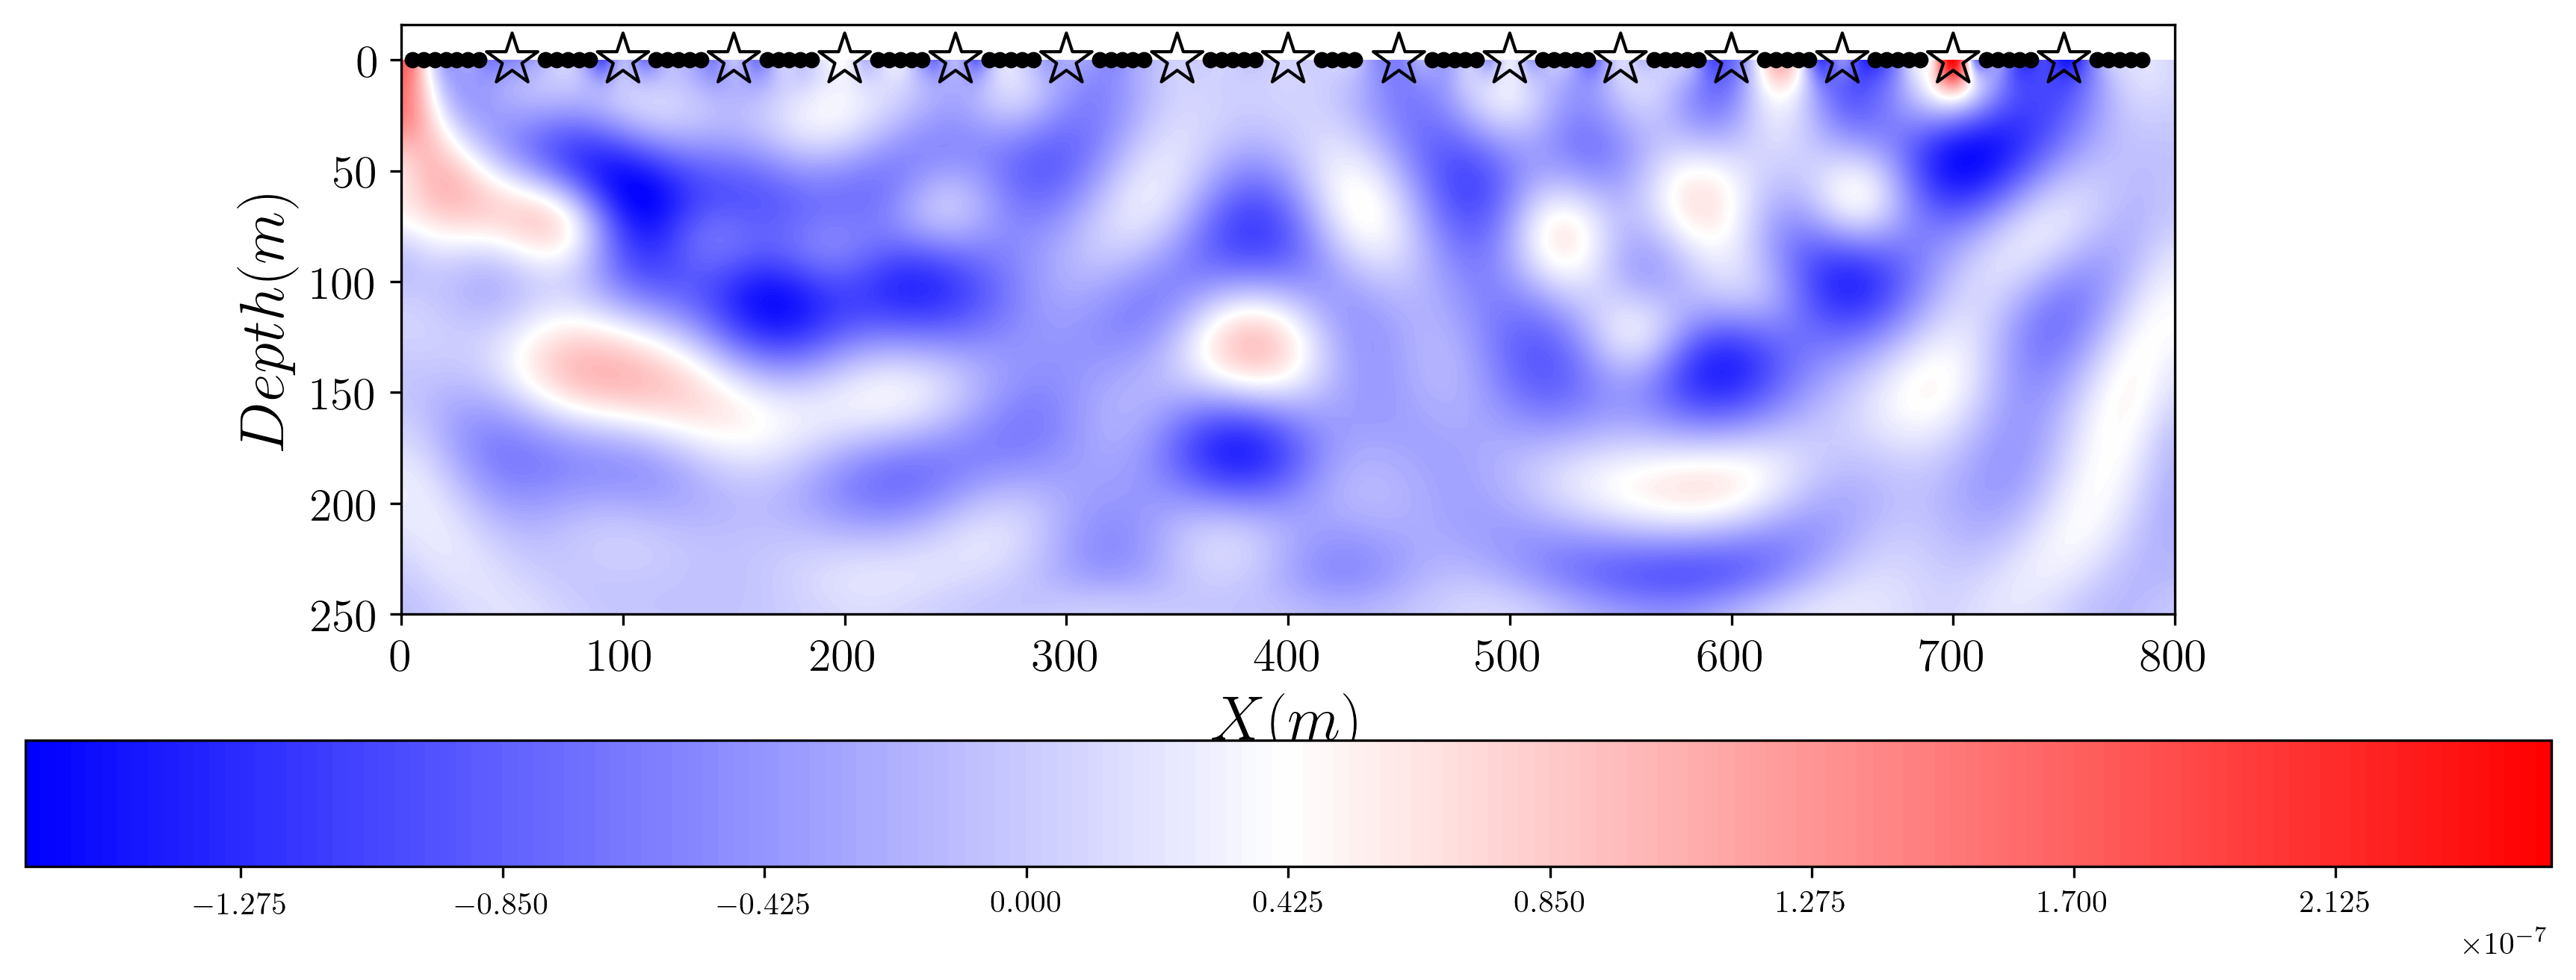

In [17]:
# bounds = np.linspace(3400, 6000, 125)
# norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

r = (max(DATA['x'][0]) - min(DATA['x'][0]))/(max(DATA['z'][0]) - min(DATA['z'][0]))
rx = r/np.sqrt(1 + r**2)
ry = 1/np.sqrt(1 + r**2)
plt.figure(figsize=(15*rx, 15*ry), dpi=300)
ax = plt.gca()
ax.invert_yaxis()
plt.tricontourf(DATA['x'][0], 250 - DATA['z'][0], DATA['vp_kernel'][0], 200)#, norm = norm)
plt.axes().set_aspect('equal') 
plt.axis(range=[0,800,-10,260])
# plt.axis

cbar = plt.colorbar(orientation='horizontal')
plt.set_cmap('bwr')
plt.scatter(xStats, 250 - zStats, color='k', marker='o',edgecolors='k',linewidths=1, s=18)
plt.scatter(xSources, 250 - np.array(zSources), c='', marker='*', edgecolors='k',s=300, linewidths=1)
plt.tick_params(labelsize=15)
#plt.title(r'$target$ $model$', fontsize = 20)

my_x_ticks = np.arange(0, 900, 100)
plt.xticks(my_x_ticks,(r'$0$',r'$100$',r'$200$',r'$300$',r'$400$',r'$500$',r'$600$',r'$700$',r'$800$',r'$900$'))
plt.yticks(np.array([0,50,100,150,200,250]),(r'$0$',r'$50$',r'$100$',r'$150$',r'$200$',r'$250$'))

plt.ylabel(r'$Depth(m)$', fontsize = 20)
plt.xlabel(r'$X(m)$', fontsize = 20)
plt.tight_layout()
# plt.savefig('./fig/' + str(ITER).zfill(3)+'.png', format='png')

In [11]:
DATA['vp_kernel']

[array([ -7.11380377e-09,  -6.78253320e-09,  -5.84211879e-09, ...,
         -6.83376200e-09,  -2.68634377e-08,  -4.09591578e-08], dtype=float32)]

In [13]:
ITER = 10
pars = ["vp_kernel"]
#pars = ["vp","vs"]
NPROC = 3
if ITER is 0:
    PATH = './output/model_init/'
elif ITER is -1:
#     PATH = './output/model_true/'
    PATH = './model_temp'
else:
    PATH = './output/gradient_' + str(ITER).zfill(4) + '/'
#PATH = './scratch/solver/000000/DATA/'

DATA = {}
for PROC in range(NPROC):
    for COORD in ['x', 'z']:
        if PROC ==0:
            DATA[COORD] = read_slice(path = './output/model_init/', parameters = [COORD], iproc = PROC)
        else:
            DATA[COORD][0] = np.append(DATA[COORD][0], read_slice(path = './output/model_init/', parameters = [COORD], iproc = PROC))
    for PAR in pars:
        if PROC == 0:
            DATA[PAR] = read_slice(path = PATH, parameters = [PAR], iproc = PROC)
        else:
            DATA[PAR][0] = np.append(DATA[PAR][0], read_slice(path = PATH, parameters = [PAR], iproc = PROC))
        

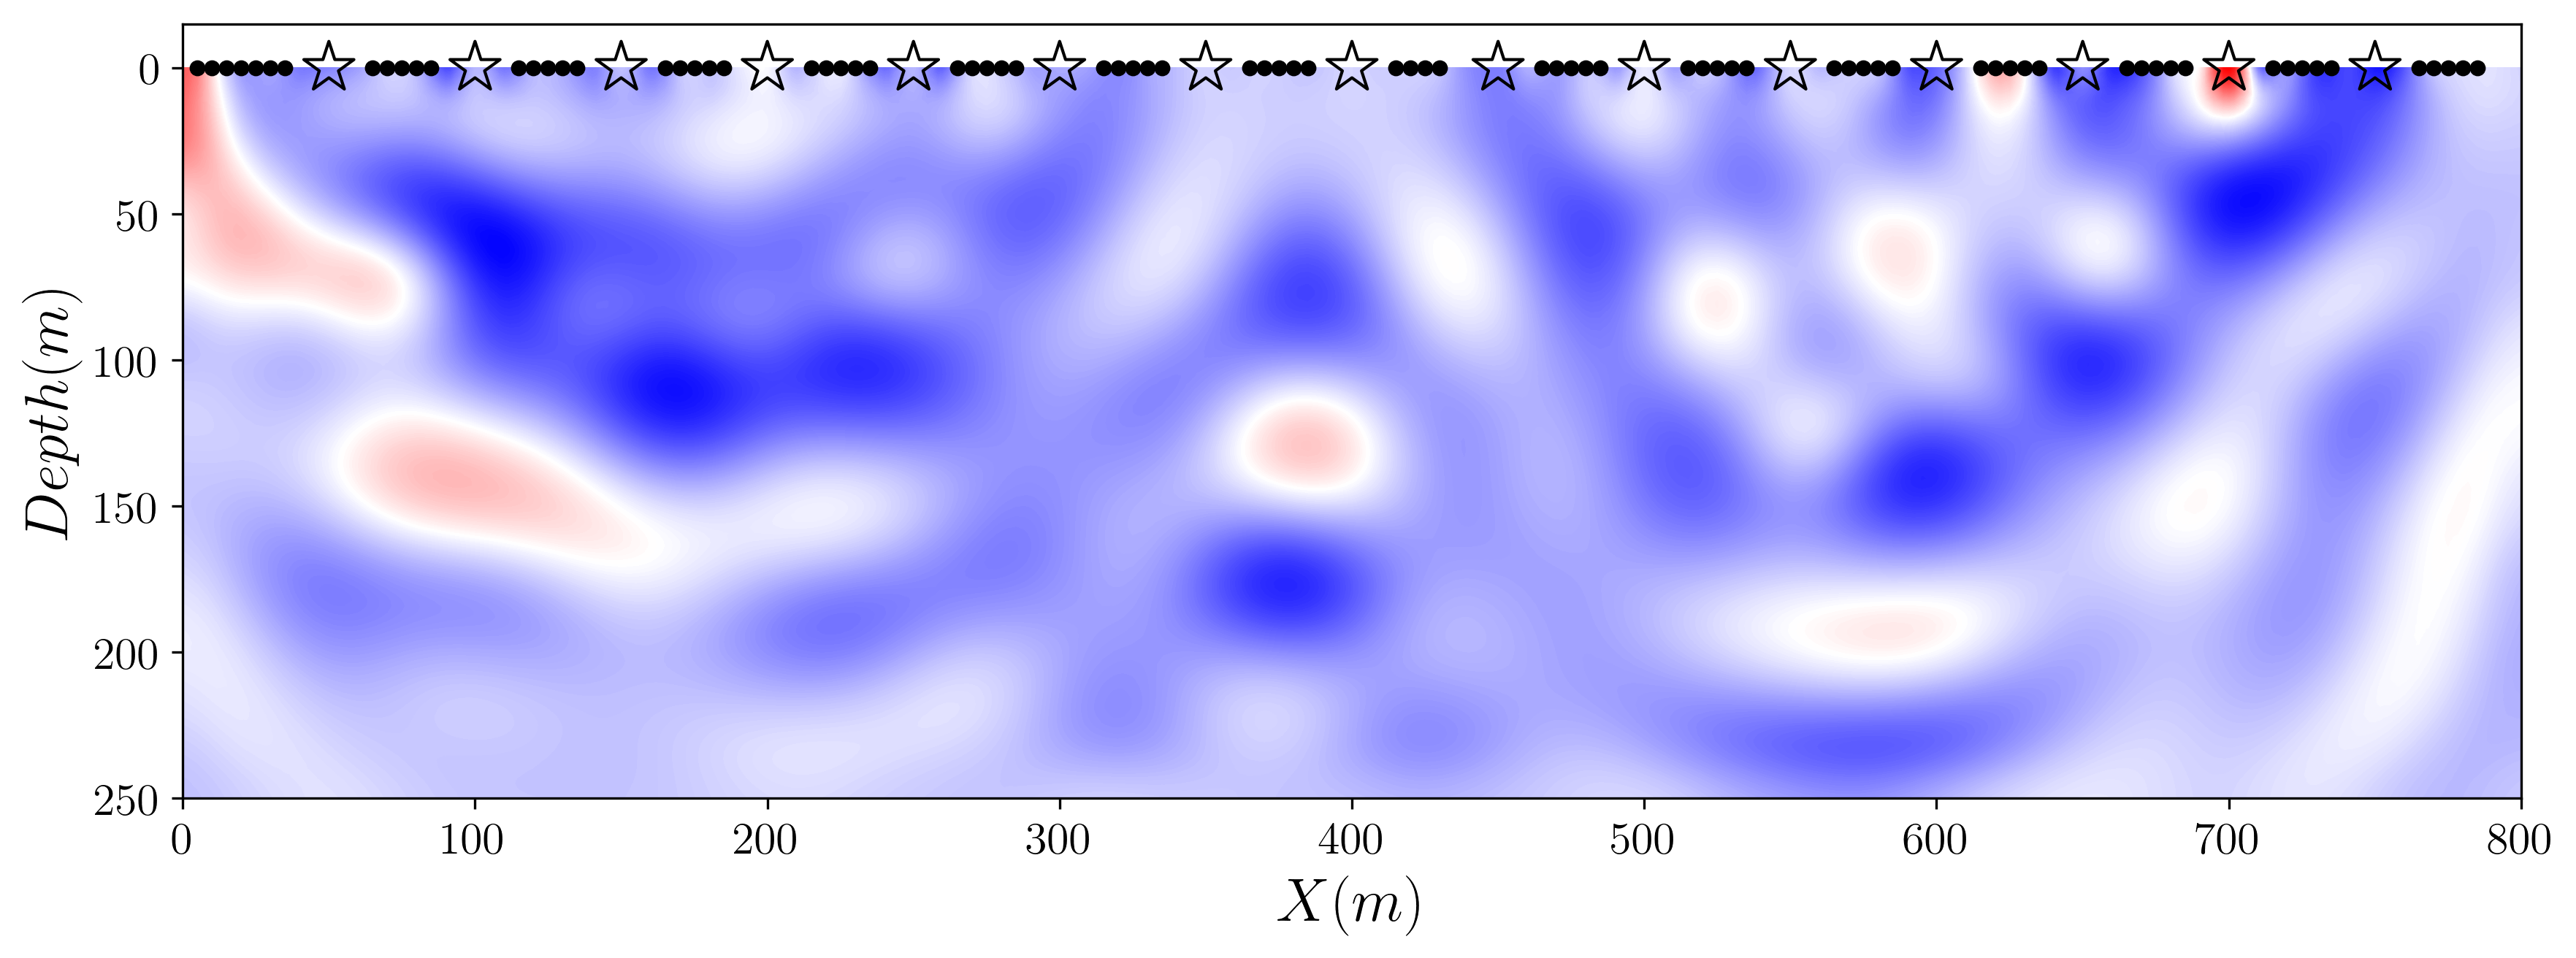

In [21]:
# bounds = np.linspace(3400, 6000, 125)
# norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

r = (max(DATA['x'][0]) - min(DATA['x'][0]))/(max(DATA['z'][0]) - min(DATA['z'][0]))
rx = r/np.sqrt(1 + r**2)
ry = 1/np.sqrt(1 + r**2)
plt.figure(figsize=(15*rx, 15*ry), dpi=300)
ax = plt.gca()
ax.invert_yaxis()
plt.tricontourf(DATA['x'][0], 250 - DATA['z'][0], DATA['vp_kernel'][0], 200)#, norm = norm)
plt.axes().set_aspect('equal') 
plt.axis(range=[0,800,-10,260])
# plt.axis

# cbar = plt.colorbar(orientation='horizontal')
plt.set_cmap('bwr')
plt.scatter(xStats, 250 - zStats, color='k', marker='o',edgecolors='k',linewidths=1, s=18)
plt.scatter(xSources, 250 - np.array(zSources), c='', marker='*', edgecolors='k',s=300, linewidths=1)
plt.tick_params(labelsize=15)
#plt.title(r'$target$ $model$', fontsize = 20)

my_x_ticks = np.arange(0, 900, 100)
plt.xticks(my_x_ticks,(r'$0$',r'$100$',r'$200$',r'$300$',r'$400$',r'$500$',r'$600$',r'$700$',r'$800$',r'$900$'))
plt.yticks(np.array([0,50,100,150,200,250]),(r'$0$',r'$50$',r'$100$',r'$150$',r'$200$',r'$250$'))

plt.ylabel(r'$Depth(m)$', fontsize = 20)
plt.xlabel(r'$X(m)$', fontsize = 20)
plt.tight_layout()
plt.savefig('./fig/1' + str(ITER).zfill(2)+'.png', format='png')



In [18]:
DATA['vp_kernel'][0]

array([ -7.11380377e-09,  -6.78253320e-09,  -5.84211879e-09, ...,
        -6.83376200e-09,  -2.68634377e-08,  -4.09591578e-08], dtype=float32)

In [38]:
misfit = []
for ITER in range(20): 
    #pars = ["vp_kernel"]
    pars = ["vp"]
    NPROC = 3
    if ITER is 0:
        PATH = './output/model_init/'
    elif ITER is -1:
    #     PATH = './output/model_true/'
        PATH = './model_temp'
    else:
        PATH = './output/model_' + str(ITER).zfill(4) + '/'
    #PATH = './scratch/solver/000000/DATA/'

    DATA = {}
    for PROC in range(NPROC):
        for PAR in pars:
            if PROC == 0:
                DATA[PAR] = read_slice(path = PATH, parameters = [PAR], iproc = PROC)
            else:
                DATA[PAR][0] = np.append(DATA[PAR][0], read_slice(path = PATH, parameters = [PAR], iproc = PROC))
    misfit.append(sum(abs(DATA['vp'][0]-truth)/truth)/truth.size)

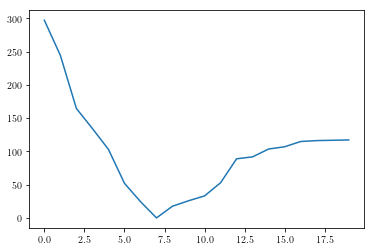

In [39]:
plt.plot(misfit)

In [50]:
ITER = -1
DATA = {}
#pars = ["vp_kernel"]
pars = ["vp"]
NPROC = 3
if ITER is 0:
    PATH = './output/model_init/'
elif ITER is -1:
    PATH = '../../../../../Desktop/Senior_thesis/APGSC/Hill/output/model_true/'
else:
    PATH = '../../../../../Desktop/Senior_thesis/APGSC/Hill/output/model_' + str(ITER).zfill(4) + '/'
#PATH = './scratch/solver/000000/DATA/'

DATA = {}
for PROC in range(NPROC):
    for PAR in pars:
        if PROC == 0:
            DATA[PAR] = read_slice(path = PATH, parameters = [PAR], iproc = PROC)
        else:
            DATA[PAR][0] = np.append(DATA[PAR][0], read_slice(path = PATH, parameters = [PAR], iproc = PROC))


In [51]:
truth = DATA['vp'][0]
truth

array([ 5343.0947,  5343.0947,  5343.0947, ...,  5663.0713,  5662.4775,
        5662.163 ], dtype=float32)

In [52]:
misfit = []
for ITER in [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85]: 
    #pars = ["vp_kernel"]
    pars = ["vp"]
    NPROC = 3
    if ITER is 0:
        PATH = './output/model_init/'
    elif ITER is -1:
    #     PATH = './output/model_true/'
        PATH = './model_temp'
    else:
        PATH = '../../../../../Desktop/Senior_thesis/APGSC/Hill/output/model_' + str(ITER).zfill(4) + '/'
    #PATH = './scratch/solver/000000/DATA/'

    DATA = {}
    for PROC in range(NPROC):
        for PAR in pars:
            if PROC == 0:
                DATA[PAR] = read_slice(path = PATH, parameters = [PAR], iproc = PROC)
            else:
                DATA[PAR][0] = np.append(DATA[PAR][0], read_slice(path = PATH, parameters = [PAR], iproc = PROC))
    misfit.append(sum(abs(DATA['vp'][0]-truth)/truth)/truth.size)

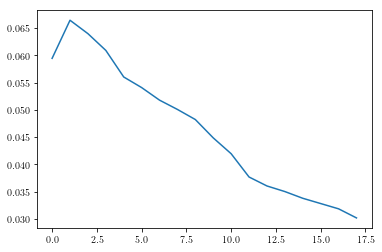

In [55]:
plt.plot(misfit)

In [3]:
st = obspy.read('./scratch/solver/000003/traces/obs/Uz_file_single.su')

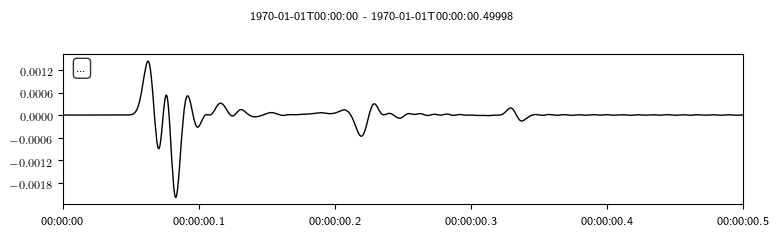

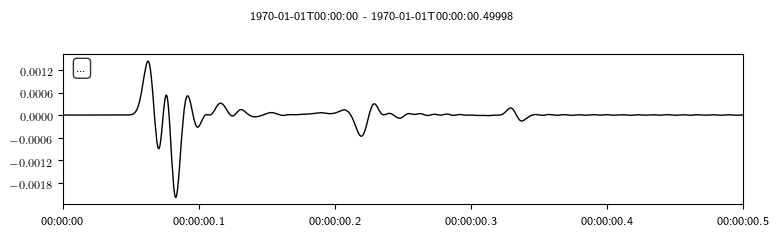

In [4]:
st[0].plot()